# REPORTE N°8

**Nombre:** Héctor Delgado Alfaro **Código:** 20200449

## LECTURA

El paper de esta semana se cuestiona sobre la repercusión economica que tuvieron las mitas (1573-1812) en la sociedad peruana y si ha dia de hoy hay algun efecto. La autora recolecta datos acercandose a los hogares en donde nacieron las mitas y a esta data le aplica una regresión discontinua. Los resultados arrojan que la mita desembocó en impactos sobre la tenencia de tierras y los bienes ya que estos territorios tuvieron menos terratenientes.

Una de sus fortalezas es haber utilizado este tipo de regresión semiparametrico y discontinuo ya que limita la muestra a los distridos ubicados dentro del territorio donde estaban las mitas y logra hacer un analisis mas preciso. Una debelidad que inclusive la autora menciona es sobre las encuestas y su poco resultado estadisticamente significativo ya que brindad poca información. Otra debilidad es propia del modelo de regresión que a veces no toma en cuenta la presencia de variables influyentes e incluso significativas pero no observables las cuales escapan del modelo de regresion discontinua.

La principal contribución del articulo recae en que como se reivindica una institucion antiquisima del Perú como es la mita en la actualidad y su repercusión en la tierra y bienes. Así mismo resalta como el tema de la desigualdad fue evolucionando y escalando a distintas etapas y formas dentro del estado peruano para con la población. En otras palabras, este paper logra cubrir un vacion que interconecte la historia colonial y el presente desigual.


## CODIGO

In [ ]:
pip install linearmodels

In [5]:
from causalgraphicalmodels import CausalGraphicalModel
import os
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns


## Explique en qué consiste el supuesto de "Relevance"

Este concepto es un supuesto importante para las variables instrumentales y explica que para que el instrumento $Z$ sea relevante este debe relacionarse con la variable explicativa $X$, asi mismo, a mayor covariación mayor confianza y si esta confianza es baja esto quiere decir que la variable instrumento no es relevante.


## Explique en qué consiste el supuesto de "Validity"

El concepto de validez es otro supuesto de las variables instrumentales y en este caso explica que el instrumento es una variable sin backdoors abiertas por lo que cualquier ruta entre el instrumento y el resultado debe pasar por el tratamiento o cerrarse. En ese sentido cualquier backdoor abierto entre $X$ y $Z$ pasa por un tratamiento bajo la responsabilidad del instrumento

## Histogramas

In [6]:
#Cargamos la dara

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file): 
    return pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/" + file)

card = read_data("card.dta")
card.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,KWW,IQ,married,libcrd14,exper,lwage,expersq,u_lwage,lwage_hat,u_educ
0,2.0,0.0,0.0,7.0,29.0,NaN,NaN,158413.0,1.0,0.0,...,15.0,NaN,1.0,0.0,16.0,6.306275,256.0,0.198047,6.108228,-3.067539
1,3.0,0.0,0.0,12.0,27.0,8.0,8.0,380166.0,1.0,0.0,...,35.0,93.0,1.0,1.0,9.0,6.175867,81.0,-0.211160,6.387027,-1.727562
2,4.0,0.0,0.0,12.0,34.0,14.0,12.0,367470.0,1.0,0.0,...,42.0,103.0,1.0,1.0,16.0,6.580639,256.0,0.204719,6.375920,1.012975
3,5.0,1.0,1.0,11.0,27.0,11.0,12.0,380166.0,1.0,0.0,...,25.0,88.0,1.0,1.0,10.0,5.521461,100.0,-0.967905,6.489366,-2.253536
4,6.0,1.0,1.0,12.0,34.0,8.0,7.0,367470.0,1.0,0.0,...,34.0,108.0,1.0,0.0,16.0,6.591674,256.0,0.125173,6.466501,1.090437


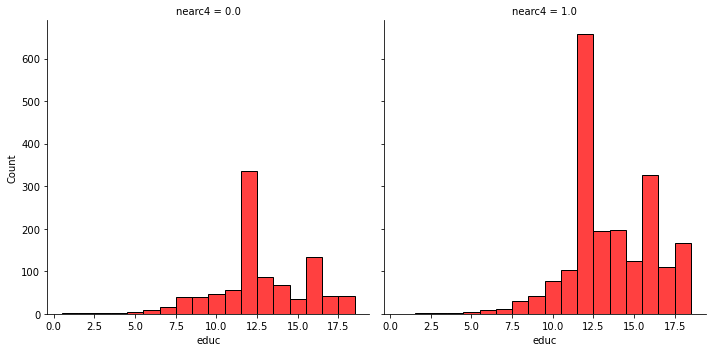

In [8]:
sns.displot(card, x = "educ", col = "nearc4", discrete=True, color = "red")

Los graficos muestran los niveles de educación alcanzados teniendo en cuenta cercanía a un college de 4 años en donde si existen variaciones entre si. El grupo de control parece que llegaría mas rapido a la meta si lo comparamos con el grupo de control.

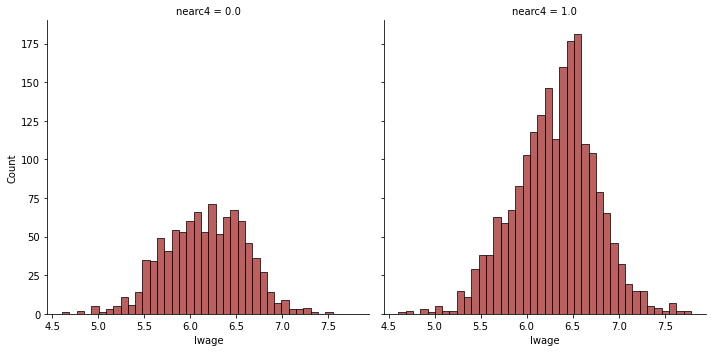

In [11]:
sns.displot(card, x="lwage", col = "nearc4", discrete=False, color = "brown")

En este caso se observa el ingreso alcanzado de los estudiantes en base a la misma variable del college de 4 años. Se observa que los hombres ganan mas cuando se encuentran en un college de 4 años.

## Regresiones

In [12]:
ols_reg = sm.OLS.from_formula("lwage ~ educ + exper + black + south + married + smsa", 
              data = card).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     219.2
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          1.97e-232
Time:                        00:53:29   Log-Likelihood:                -1273.9
No. Observations:                3003   AIC:                             2562.
Df Residuals:                    2996   BIC:                             2604.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0633      0.064     79.437      0.000       4.938       5.188
educ           0.0712      0.003     20.438      0.000       0.064       0.078
exper          0.0342      0.002     15.422      0.000       0.030       0.038
black         -0.1660      0.018     -9.426      0.000      -0.201      -0.131
south         -0.1316      0.015     -8.788      0.000      -0.161      -0.102
married       -0.0359      0.003    -10.547      0.000      -0.043      -0.029
smsa           0.1758      0.015     11.372      0.000       0.145       0.206
==============================================================================
Omnibus:                       53.196   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.430
Skew:                          -0.231   Prob(JB):                     8.38e-16
Kurtosis:                       3.584   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La regresion arroja los resultados y muestra que cada año de estudios cursado adicional, los ingresos aumentan en 7.1% y al nivel de ingresos sigue creciendo un 3.4% si se le agrega 1 año de experiencia.Asi mismo, se observan cuestiones que reducen los niveles de ingreso que puede estar ligados a la discriminacion latente en la sociedad como el tema de la raza negra que reduce los ingresos percibidos en un 16% o inclusive la vivencia de una persona en el sur que la reduce en un 13%. Estos resultados son significativos si observamos el F-statistic 
 

## ------

In [13]:
card['married'] = card['married'].fillna(0) #errores

iv_reg = IV2SLS.from_formula("lwage ~  1 + exper + black + south + married + smsa + [educ ~ nearc2 ]", card).fit()
iv_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                  lwage   R-squared:                     -1.3114
Estimator:                    IV-2SLS   Adj. R-squared:                -1.3160
No. Observations:                3010   F-statistic:                    289.62
Date:                Mon, Nov 14 2022   P-value (F-stat)                0.0000
Time:                        00:55:28   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.1276     3.1412     0.0406     0.9676     -6.0290      6.2843
black          0.1134     0.1816     0.6244     0.5324     -0.2425      0.4692
exper          0.1515     0.0747     2.0274     0.0426      0.0050      0.2980
married       -0.0151     0.0147    -1.0258     0.3050     -0.0438      0.0137
smsa           0.0201     0.1030     0.1949     0.8455     -0.1819      0.2220
south         -0.0319     0.0692    -0.4603     0.6453     -0.1675      0.1038
educ           0.3618     0.1849     1.9562     0.0504     -0.0007      0.7243
==============================================================================

Endogenous: educ
Instruments: nearc2
Robust Covariance (Heteroskedastic)
Debiased: False
"""

La regresion parte de una variable instrumental al codificar el primer codigo y partimos de que no es un modelo debil si observamos el F statistic. En este caso hay una variacion del 36% en comparacion del 7% del modelo anterior respecto a los ingresos por cada año de estudios. En el caso de la experiencia, la diferencia tambien se da aunque en menor grado ya que solo supera al modelo anterior en 11.6% (15% de aumento para este modelo vs 3.4% para el anterior). En este caso, la raza no parece reducir los niveles de ingresos, algo dificil de percibir en una sociedad aun racista y discriminatoria. Las personas que viven en el sur tambien perciben menos ingresos aunque con menor margen en comparacion con el modelo anterior.
